<a href="https://colab.research.google.com/github/agnesmtyas/Heart-Disease-Prediction-using-Machine-Learning/blob/master/Heart%20Disease%20Prediction%20using%20Random%20Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Data Preparation**

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Proses extract data
data_heart = pd.read_csv('https://raw.githubusercontent.com/agnesmtyas/Heart-Disease-Prediction-using-Machine-Learning/refs/heads/master/heart.csv')

# Tampilkan data
data_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# **2. Informasi Umum pada Data**

In [ ]:
# Mengecek informasi data
data_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Berikut kolom pada dataset:
*   age = umur pasien
*   sex = jenis kelamin pasien
*   cp (chest pain type) = jenis nyeri dada (4 values)
*   trestbps (resting blood pressure) = tekanan darah ketika beristirahat
*   chol (serum cholestoral) = kadar kolesterol serum dalam mg/dl
*   fbs (fasing blood sugar) = kadar gula darah dalam keadaan puasa > 120 mm/Hg
*   restecg (resting electrocardiographic result) = hasil elektrokardiogram saat istirahat (values 0,1,2)
*   thalach (maximum heart rate achieced) = denyut antung maksimum selama tes latihan
*   exang (exercise induced angina) = mengindikasikan apakah angina (nyeri dada) dipicu oleh latihan fisik
*   oldpeak (ST depression induced by exercise to rest) = mengukur depresi segment ST (perubahan dalam garis dasar elektrokardiogram) yang disebabkan oleh latihan fisik
*   slope = kemiringan segment ST selama tes latihan
*   ca (number of major vessels colored by flourosopy) = mengukur jumlah pembuluh darah utama yang terlihat dengan jelas melalui pewarnaan fluroskopi (values 0,1,2,3)
*   thal = hasil tes thalium (radiosotop) untuk mendeteksi aliran darah ke jantung (1 = fixed defect; 2 = reversable defect)
*   target = diagnosa penyakit jantung (**0 = tidak terindikasi penyakit jantung dan 1 = terindikasi penyakit jantung**)

In [ ]:
# Menentukan fitur numerik
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identifikasi tipe data fitur yang perlu diubah menjadi object
feature_converted = [feature for feature in data_heart.columns if feature not in numeric_features]

# Mengubah tipe data menjadi object
data_heart[feature_converted] = data_heart[feature_converted].astype('object')

data_heart.dtypes

,0
age,int64
sex,object
cp,object
trestbps,int64
chol,int64
fbs,object
restecg,object
thalach,int64
exang,object
oldpeak,float64


In [ ]:
# Menampilkan deskripsi statistik untuk fitur numerik
data_heart.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [ ]:
# Menampilkan deskripsi statistik untuk fitur kategorikal
data_heart.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,1025,1025,1025,1025,1025,1025,1025,1025,1025
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,1,0,2,1
freq,713,497,872,513,680,482,578,544,526


`**Tipe Data**
*   Kategorik : tipe data yang terdiri dari variabel kategori atau data hasil pengelompokan berdasarkan kategori tertentu. Fitur yang memiliki tipe data nominal adalah **sex**, **cp**, **fbs**, **restecg**, **exang**, **slope**, **ca**, **thal**, dan **target**.
*   Numerik : semua jenis data yang berisi angka. Fitur yang memiliki tipe data numerik adalah **age**, **trestbps**, **chol**, **thalach**, **oldspeak**.



# **3. Exploratory Data Analysis (EDA)**

## **3.1 Visualisasi Univariate**
Akan dilakukan eksplorasi data dengan melihat visualisasi data secara univariate (1 variabel) pada beberapa fitur.

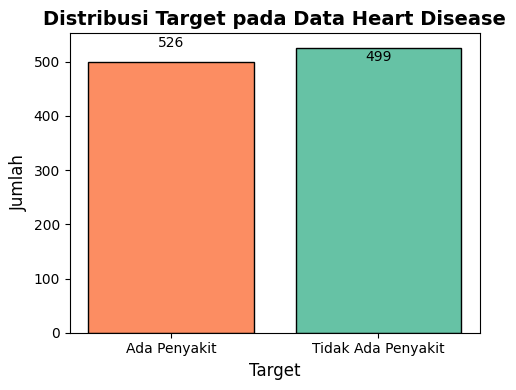

In [ ]:
# Hitung jumlah dan proporsi targer
total_data = data_heart['target'].value_counts().reset_index()
total_data['proportion'] = ((total_data['count'] / total_data['count'].sum()).round(2))

# Buat bar chart
plt.figure(figsize=(5, 4))
plt.bar(total_data['target'], total_data['count'], color=['#66c2a5', '#fc8d62'], edgecolor='black')
plt.title('Distribusi Target pada Data Heart Disease', fontsize=14, fontweight='bold')
plt.xlabel('Target', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(total_data['target'], labels=['Tidak Ada Penyakit', 'Ada Penyakit'], fontsize=10)

for i, count in enumerate(total_data['count']):
    plt.text(i, count + 2, str(count), ha='center', fontsize=10, color='black')

# Tampilkan grafik
plt.tight_layout()
plt.show()

> Total seluruh pasien adalah 1205 pasien dengan sebanyak 499 pasien tidak memiliki penyakit jantung (49%) sedangkan sebanyak 526 pasien mengidap penyakit jantung (51%). Hal ini berarti bahwa data sudah cukup seimbang.

Untuk data numerik, akan dibuat histogram untuk dilihat distribusi pada masing-masing fitur sehingga dapat diketahui persebaran dan bentuk distribusi dataset.

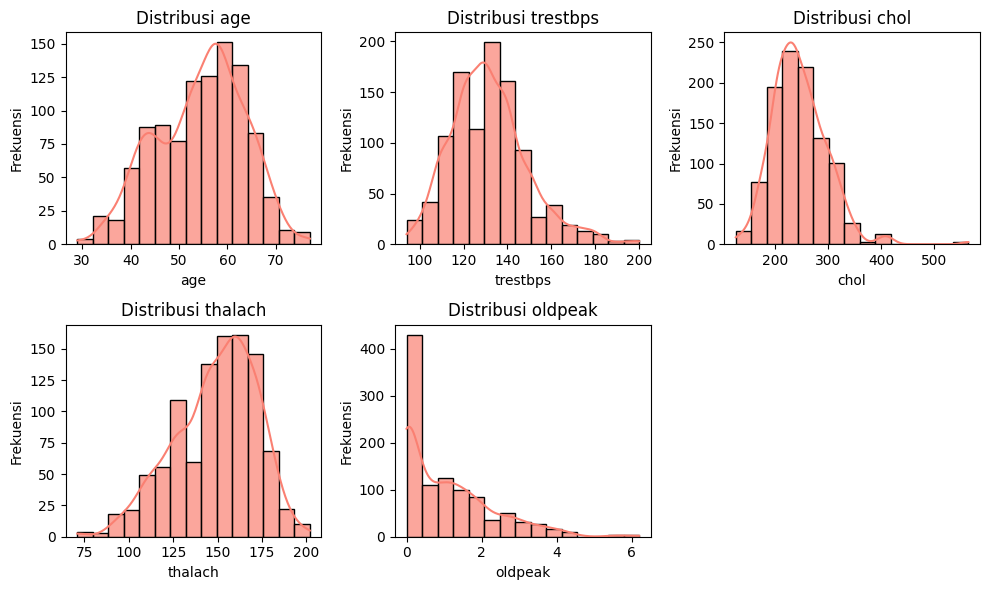

In [ ]:
# Buat figure dengan subplot
plt.figure(figsize=(10,6))

# Loop untuk setiap fitur
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)  # Membuat grid 2x3 untuk subplot
    sns.histplot(data_heart[feature], bins=15, kde=True, color='salmon', edgecolor='black', alpha=0.7)
    plt.title(f'Distribusi {feature}', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frekuensi', fontsize=10)

plt.tight_layout()
plt.show()


* **age**: distribusi umur cenderung normal atau no skewed.

* **trestbps**: distribusi tekanan darah pasien yaitu cenderung normal atau no skewed.

* **chol**: distribusi kolesterol yaitu cenderung normal atau no skewed.

* **thalach**: distribusi denyut maksimal yaitu condong ke kiri atau left skewed.

* **oldpeak**: distribusi condong ke kanan atau right skewed.

> Secara keseluruhan, tidak terdapat gangguan/noise pada data.

Untuk data kategorikal, akan dilihat diagram batang pada masing-masing fitur.

In [ ]:
categorical_features = data_heart.columns.difference(numeric_features)

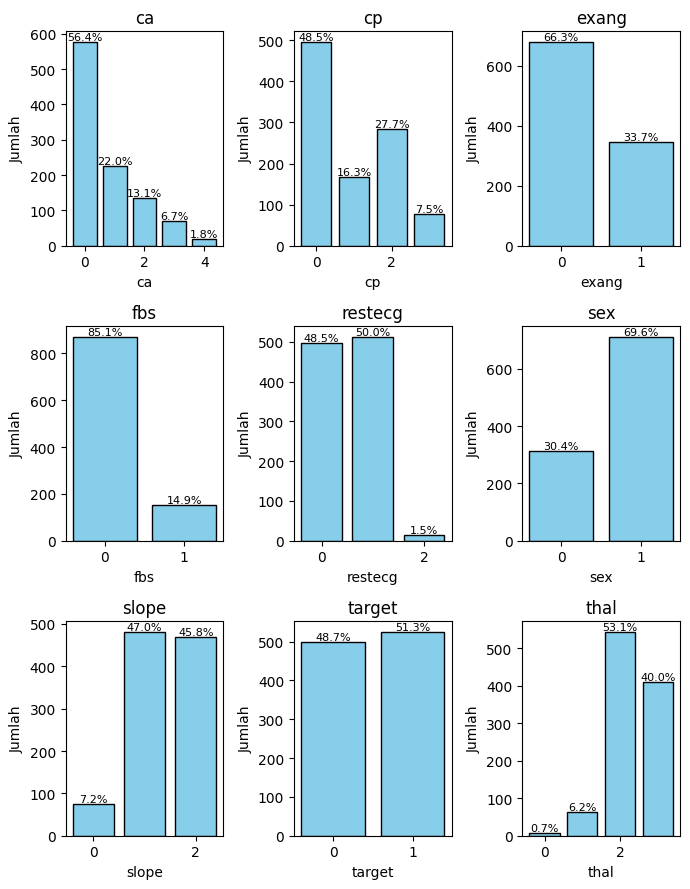

In [ ]:
# Membuat figure dengan subplot
plt.figure(figsize=(7, 9))

# Loop untuk setiap fitur
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    counts = data_heart[feature].value_counts()
    percentages = (counts / counts.sum()) * 100

    # Bar chart
    bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Jumlah', fontsize=10)
    plt.xticks(rotation=0)

    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

* fitur **ca** (jumlah pembuluh darah utama) didominasi oleh "0" sebesar 56,4%
* fitur **cp** (jenis nyeri dada) didominasi oleh tipe "0" sebesar 40,5%
* data didominasi oleh pasien yang tidak mempunyai angina (**exang**) sebesar 55,3%
* data didominasi oleh pasien yang mempunyai kadar gula (**fbs**) < 120 mm/Hg
* hasil elektrokardiogram (**restecg**) didominasi oleh "0" dan "1"
* jenis kelamin (**sex**) didominasi oleh wanita
* **slope** didominasi oleh "1" dan "2"
* pasien yang memiliki penyakit jantung dan tidak (**target**) hampir seimbang
* hasil tes thalium (**thal**) didominasi oleh "2"

## **3.2 Visualisasi Multivariate**
Akan dilakukan eksplorasi data dengan melihat visualisasi data secara multivariate pada beberapa fitur.

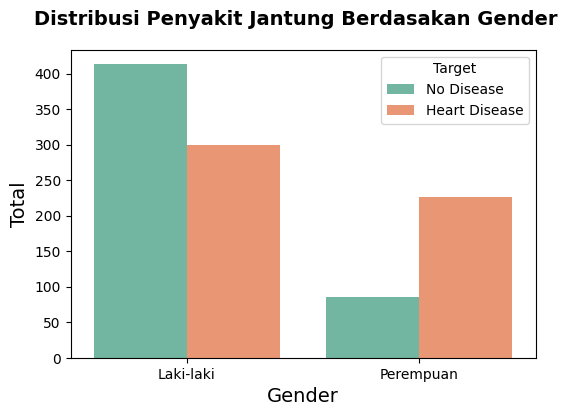

In [ ]:
# Bar chart untuk distribusi target berdasarkan jenis kelamin
plt.figure(figsize=(6,4))
sns.countplot(x=data_heart['sex'].replace({0: 'Perempuan', 1: 'Laki-laki'}), hue=data_heart['target'], palette='Set2')

plt.suptitle('Distribusi Penyakit Jantung Berdasakan Gender', fontweight='heavy',
            fontsize=14, fontfamily='sans-serif')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Total', fontsize=14)
plt.legend(title='Target', labels=['No Disease', 'Heart Disease'])

plt.show()

>**Interpretasi:**
Grafik menunjukkan bahwa pria lebih banyak terkena penyakit jantung. Namun, jika dilihat dari perbandingan maka wanita cenderung lebih banyak terkena penyakit jantung dibandingkan yang tidak terkena penyakit.

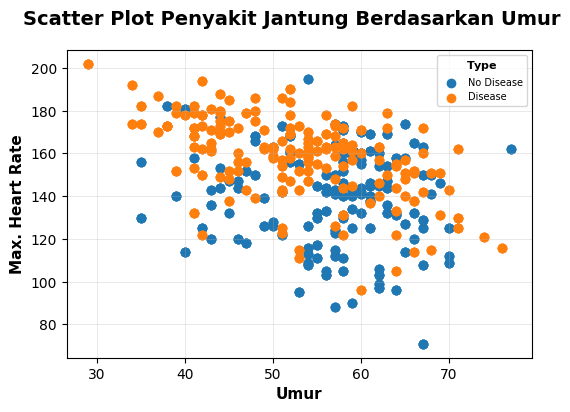

In [ ]:
# Scatter Plot Penyakit Jantung Berdasarkan Umur
plt.figure(figsize=(6, 4))
plt.suptitle('Scatter Plot Penyakit Jantung Berdasarkan Umur', fontweight='heavy', fontsize='14', fontfamily='sans-serif')

# Membuat Scatter Plot
plt.scatter(x=data_heart.age[data_heart.target==0], y=data_heart.thalach[(data_heart.target==0)])
plt.scatter(x=data_heart.age[data_heart.target==1], y=data_heart.thalach[(data_heart.target==1)])

plt.legend(['No Disease', 'Disease'], title='$\\bf{Type}$', fontsize='7',
           title_fontsize='8', loc='upper right', frameon=True)

plt.xlabel('Umur', fontweight='bold', fontsize='11',
           fontfamily='sans-serif')

plt.ylabel('Max. Heart Rate', fontweight='bold', fontsize='11',
           fontfamily='sans-serif')

plt.ticklabel_format(style='plain', axis='both')
plt.grid(axis='both', alpha=0.4, lw=0.5)
plt.show();

**Interpretasi:** Berdasarkan scatter plot, pasien dengan penyakit jantung maupun tidak terkena penyakit jantung tersebar di umur 30 sampai 70. Selain itu, penyakit jantung lebih banyak diderita oleh pasien dengan detak jantung maksimal di atas 140 detak per menit.

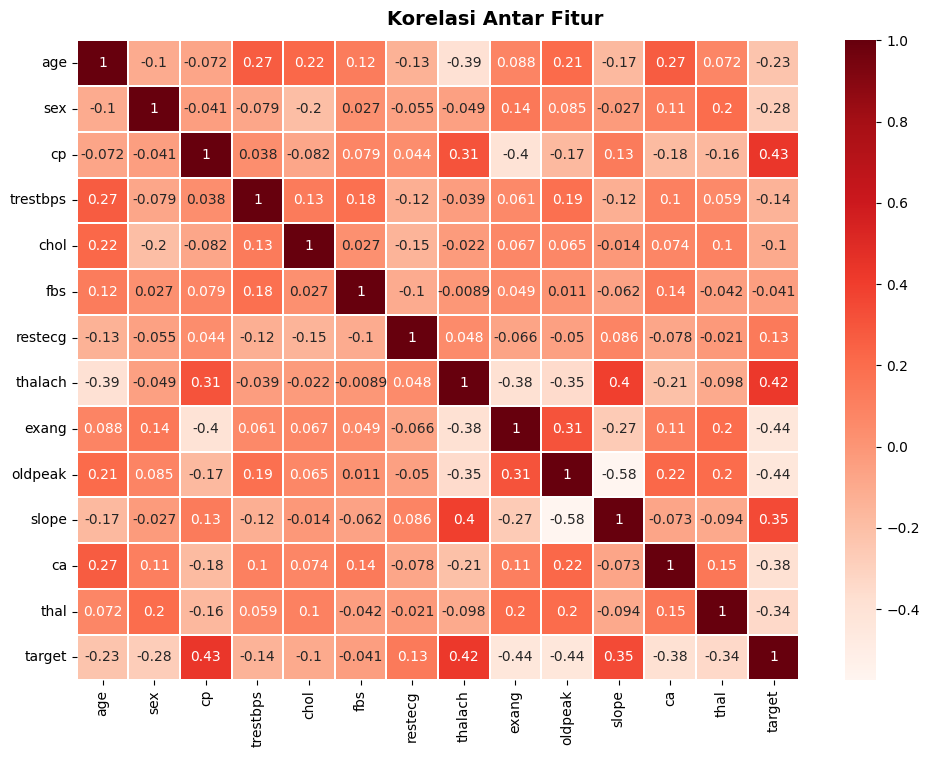

In [ ]:
# Korelasi Antar Fitur dengan Heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(data_heart[['age', 'sex','cp', 'trestbps', 'chol','fbs', 'restecg','thalach','exang', 'oldpeak','slope',	'ca',	'thal',	'target']].corr(), annot=True, cmap='Reds', linewidths=0.1)

plt.suptitle('Korelasi Antar Fitur', fontweight='heavy',
           fontsize='14', fontfamily='sans-serif')

plt.tight_layout(rect=[0, 0.04, 1, 1.01])

**Interpretasi:**

**cp, thalach, dan slope** memiliki korelasi positif dengan target, semakin besar cp, thalach, dan slope maka akan berpengaruh pada kemungkinan menderita penyakit jantung.

**exang, oldpeak, ca, dan thal** memiliki korelasi negatif dengan, semakin besar fitur exang, oldpeak, ca, dan thal maka kemungkinan memiliki penyakit jantung akan rendah

# **4. Data Preprocessing**
Data preprocessing adalah proses persiapan dan transformasi data mentah menjadi format yang lebih terstruktur dan siap analisis. Preprocessing data tidak hanya meningkatkan kualitas dan keakuratan data, tetapi juga memiliki peran penting dalam memastikan efektivitas model.

## **1.1 Missing Value**

In [ ]:
# Memeriksa missing value
missing_data = data_heart.isnull().sum()

print(missing_data)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


> **Interpretasi:** Tidak ada missing value pada setiap kolom data heart disease.

## **1.2 Outliers**
Adanya outlier memberikan dampak signifikan terhadap hasil anaisis dan berpotensi menghasilkan kesimpulan yang tidak akurat. Maka dari itu, akan dilihat terlebih dahulu outlier pada fitur numerik, yaitu age, chol, trestbps, thalach, dan oldpeak dengan cara menampilkan boxplot masing-masing fitur.

In [ ]:
numeric_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
# Melihat outlier melalui boxplot
colors = ['#0A1D56', '#492E87', '#37B5B6','#2C7865','#FF9800']

for col, colour in zip(numeric_features, colors):
    fig = px.box(
        data_heart[col],
        orientation = 'h',
        color_discrete_sequence  = [colour]
    )

    fig.update_layout(
        title = f'<b>Box Plot {col}</b>',
        width=800,
        height=300,
        yaxis = dict(
            title = '',
            showgrid = False,
            showline = False,
            showticklabels = False,
            zeroline = False,
        ),
        xaxis = dict(
            title = col,
            showgrid = False,
            showline = True,
            showticklabels = True,
            zeroline = False,
        )
    )

    # Tampilkan grafik
    fig.show()

In [ ]:
# Melihat banyaknya outlier
Q1 = data_heart[numeric_features].quantile(0.25)
Q3 = data_heart[numeric_features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_count = ((data_heart[numeric_features] < lower_bound) | (data_heart[numeric_features] > upper_bound)).sum()

outliers_count

,0
age,0
trestbps,30
chol,16
thalach,4
oldpeak,7


In [ ]:
outliers_count = ((data_heart[numeric_features] < lower_bound) | (data_heart[numeric_features] > upper_bound)).sum()
outliers_count.sum()

57

> Ada sebanyak 57 outlier. Nilai outlier akan diubah menjadi nilai lower_bound atau upper_bound. Untuk meningkatkan keakuratan dan kualitas data, outlier akan outlier tersebut akan diubah menjadi batas bawah/batas atas.

In [ ]:
# Menarik nilai outlier ke dalam batas
data_heart_clipped = data_heart.copy()
for col in numeric_features:
    data_heart_clipped[col] = data_heart_clipped[col].clip(lower=lower_bound[col], upper=upper_bound[col])

outliers_count_new = ((data_heart_clipped[numeric_features] < lower_bound) | (data_heart_clipped[numeric_features] > upper_bound)).sum()
outliers_count_new.sum()

0

> Sudah tidak ada lagi outlier

## **4.1 Encoding**
Encoding diperlukan untuk fitur dengan tipe data kategorik yang sebelumnya berupa angka, dipisah dengan membuat fitur baru sehingga asumsi urutan tidak lagi ada dalam fitur tersebut. Fitur kategori yang perlu dilakukan one-hot encoding, yaitu **cp, restecg,** dan **thal**.

In [ ]:
# On-Hot encoding untuk fitur cp, restecg, dan thal
data_heart1 = pd.get_dummies(data_heart, columns=['cp', 'restecg', 'thal'], dtype=int)

# Ubah fitur kategorikal yang tidak perlu one-hot encoding menjadi integer
features_converted = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_converted:
    data_heart1[feature] = data_heart1[feature].astype(int)

data_heart1.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,...,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,thal_0,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,2,2,...,0,0,0,0,1,0,0,0,0,1
1,53,1,140,203,1,155,1,3.1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,70,1,145,174,0,125,1,2.6,0,0,...,0,0,0,0,1,0,0,0,0,1
3,61,1,148,203,0,161,0,0.0,2,1,...,0,0,0,0,1,0,0,0,0,1
4,62,0,138,294,1,106,0,1.9,1,3,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
data_heart1.dtypes

,0
age,int64
sex,int64
trestbps,int64
chol,int64
fbs,int64
thalach,int64
exang,int64
oldpeak,float64
slope,int64
ca,int64


## **4.2 Split Data**
Data dipisahkan menjadi data training untuk melatih model sebesar 75% dan data testing untuk menguji model sebesar 25%.

In [ ]:
# Memisahkan fitur dan target
X = data_heart1.drop('target', axis=1) # variabel independen
y = data_heart1['target'] # variabel dependen

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state = 0
)

In [ ]:
# Periksa ukuran masing-masing data
print("Jumlah data awal         :", data_heart1.shape[0], "baris")
print("Jumlah data train (75%)  :", X_train.shape[0], "baris")
print("Jumlah data test (25%)    :", X_test.shape[0], "baris")

Jumlah data awal         : 1025 baris
Jumlah data train (75%)  : 768 baris
Jumlah data test (25%)    : 257 baris


# **5 Random Forest Algorithm**
Random forest merupakan algoritma machine learning berbasis ensemble yang menggunakan kombinasi dari decision tree untuk meningkatan akurasi prediksi dan stabilitas prediksi, serta mengurangi overfitting.

### **5.1 Fitting Model**

In [ ]:
# Buat objek model
rf = RandomForestClassifier(random_state=0)

# Fit model ke data training
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# Parameter default
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Definisikan hyperparameter
param_grid_rf = {
    'n_estimators': [10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1 ,2 ,3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False]
}

In [ ]:
# Proses mencari hyperparameter terbaik
grid_search_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring='recall'
)

grid_search_rf.fit(X_train, y_train)

#  Hasil hyperparameter tuning
print("Best Hyperparameters: ", grid_search_rf.best_params_)
print("Best Score: {:.2f}".format(grid_search_rf.best_score_))

Best Hyperparameters:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
Best Score: 0.91


### **5.2 Confusion Matrix and Evaluation**

> Metric evaluation yang digunakan adalah **recall** karena recall menyatakan sejauh mana model dapat mengidentifikasi dengan benar semua sampel positif yang ada. Recall dipilih pada kasus ini karena akan lebih baik model memprediksi pasien memiliki penyakit jantung padahal tidak memiliki penyakit jantung, daripada model memprediksi pasien tidak memiliki penyakit jantung padahal pasien memliliki penyakit jantung, hal tersebut akan lebih fatal.

In [ ]:
# Membuat confusion matrix untuk data train
cm_train = confusion_matrix(y_train, grid_search_rf.predict(X_train))

# Heat Map
fig = px.imshow(
    cm_train,
    labels=dict(x="Prediksi", y="Aktual"),
    x = ['No Disease', 'Heart Disease'],
    y = ['No Disease', 'Heart Disease'],
    text_auto = True,
    color_continuous_scale = 'Reds'
)

fig.update_coloraxes(
    showscale = False
)

fig.update_layout(
    width = 800,
    height = 600,
    title = dict(
        text = "<b>Confusion Matrix Prediksi Heart Disease</b>",
        font = dict(
            size = 25,
            color = '#D04848'
        ),
        y = 0.95,
        x = 0.5
    ),
    margin = dict(
        t = 80,
        b = 30,
        r = 50,
        l = 50
    )
)

fig.show()

In [ ]:
# Evaluasi optimasi model pada data train
print(classification_report(y_train, grid_search_rf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       376
           1       0.82      0.87      0.85       392

    accuracy                           0.84       768
   macro avg       0.84      0.84      0.84       768
weighted avg       0.84      0.84      0.84       768



> **Confusion Matrix dan Evaluasi untuk data train menunjukkan bahwa:**
* Model berhasil memprediksi bahwa pasien tidak menderita penyakit jantung sebesar 80%.
* Model berhasil memprediksi bahwa pasien menderita penyakit jantung sebesar 87%.

In [ ]:
# Membuat confusion matrix untuk data test
cm_test = confusion_matrix(y_test, grid_search_rf.predict(X_test))

# Heat Map
fig = px.imshow(
    cm_test,
    labels=dict(x="Prediksi", y="Aktual"),
    x = ['No Disease', 'Heart Disease'],
    y = ['No Disease', 'Heart Disease'],
    text_auto = True,
    color_continuous_scale = 'Reds'
)

fig.update_coloraxes(
    showscale = False
)

fig.update_layout(
    width = 800,
    height = 600,
    title = dict(
        text = "<b>Confusion Matrix Prediksi Heart Disease</b>",
        font = dict(
            size = 25,
            color = '#D04848'
        ),
        y = 0.95,
        x = 0.5
    ),
    margin = dict(
        t = 80,
        b = 30,
        r = 50,
        l = 50
    )
)

fig.show()

In [ ]:
# Evaluasi optimasi model pada data test
print(classification_report(y_test, grid_search_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       123
           1       0.84      0.90      0.87       134

    accuracy                           0.86       257
   macro avg       0.86      0.86      0.86       257
weighted avg       0.86      0.86      0.86       257



> **Confusion Matrix dan Evaluasi untuk data test menunjukkan bahwa:**
* Model berhasil memprediksi bahwa pasien tidak menderita penyakit jantung sebesar 81%.
* Model berhasil memprediksi bahwa pasien menderita penyakit jantung sebesar 90%.

### **5.3 Cross Validation**
Cross validation adalah salah satu model yang digunakan untuk mengukur seberapa baik kinerja model machine learning. Tujuannya adalah untuk menghindari overfitting dan memperoleh perkiraan yang lebih konsisten tentang seberapa baik model akan berkinerja.

In [ ]:
# Membuat objek KFold dengan k=5
stratified_kfold = StratifiedKFold(n_splits = 5)

# Melakukan cross-validation menggunakan 5-fold cross-validation
scores = cross_val_score(
    estimator = grid_search_rf.best_estimator_,
    X = X_train,
    y = y_train,
    cv = stratified_kfold,
    scoring = 'recall'
)

# Menampilkan hasil cross-validation
print(f'Hasil Cross-Validation : {scores}')
print(f'Rata-rata Skor         :{scores.mean(): .3f}')
print(f'Simpangan baku Skor    :{scores.std(): .3f}')

Hasil Cross-Validation : [0.8974359  0.89873418 0.88607595 0.92307692 0.92307692]
Rata-rata Skor         : 0.906
Simpangan baku Skor    : 0.015


> Hasil menunjukkan bahwa model memiliki tingkat akurasi 91% dengan standar deviasi sebesar 1,5%. Hal ini menunjukkan bahwa model memiliki kinerja yang baik dan stabil secara keseluruhan dalam memprediksi kelas target pada dataset Heart Disease.

# **6. Feature Importance**

Feature Importance menunjukkan seberapa sering suatu atribut digunakan dalam membangun pohon yaitu dengan menghitung information gain. Semakin tinggi nilai tersebut, semakin tinggi tingkat kepentingan atribut tersebut.

      Feature  Importance
9          ca    0.333333
10       cp_0    0.166667
19     thal_2    0.100000
5     thalach    0.100000
6       exang    0.066667
7     oldpeak    0.066667
20     thal_3    0.066667
8       slope    0.033333
11       cp_1    0.033333
12       cp_2    0.033333
4         fbs    0.000000
3        chol    0.000000
1         sex    0.000000
13       cp_3    0.000000
14  restecg_0    0.000000
15  restecg_1    0.000000
16  restecg_2    0.000000
17     thal_0    0.000000
18     thal_1    0.000000
2    trestbps    0.000000
0         age    0.000000


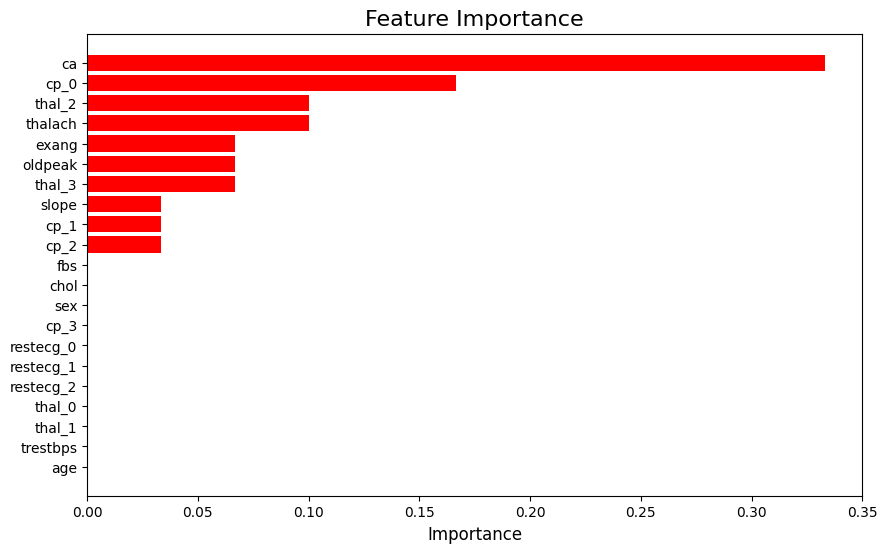

In [ ]:
# Feature Importance dari model terbaik GridSearchCV
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# Membuat DataFrame
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Visualisasi Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')
plt.gca().invert_yaxis()
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance', fontsize=16)
plt.show()

> Fitur dengan importance tinggi adalah faktor utama yang harus diperhatikan saat menganalisis, yaitu:
* **ca** = jumlah pembuluh darah besar yang terlihat pada fluoroskopi
* **cp_0** = tipe nyeri dada kategori 0
* **thal_2** = hasil tes thalium kategori 2
* **thalach** = detak jantung maksimum